In [1]:
import pandas as pd
import numpy as np
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve 

from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


from sklearn.svm import SVC

from sklearn.model_selection import KFold, cross_val_score

import copy
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Setup Dataframe

In [2]:
df = pd.read_csv("Covid-19_dataset.csv",header=1)
# df['is_Male'] = pd.get_dummies(df['Gender'])['MALE']
#one hot encoding gender so male = #1 and female = 0
# df['is_Female'] = pd.get_dummies(df['Gender'])['FEMALE']

In [3]:
df_bloodType = pd.get_dummies(df['Blood_Group'])
blood_type_labels = df_bloodType.columns

# Remove unwanted features and set up One Hot Encoding

In [4]:
blacklist = ['Age',' Incubation period (days)','Blood_Group','CONTROL_blood_group','Risk_Factor','Infection_type','Gender','Place_of_isolation','Patient_In','Patient_out']
labels = ['Severeity','Outcome']
df = df.drop(blacklist,axis=1)
df

,Severeity,Outcome,Fever,Chills,Cough,Dyspnea,Anosmia_Ageusia,Loss_of_appetite,Asthenia,Headache,Muscle_ache,Cyanosis,Rhinorrhea,Sore_throat,Diarrhea,Nausea_vomiting
0,Moderate,Recovered,1,1,1,1,1,1,1,1,1,0,0,1,1,0
1,Mild,Recovered,1,0,1,0,1,1,1,1,1,0,0,1,1,1
2,Severe,Died,1,1,1,1,0,0,1,1,0,1,0,1,0,0
3,Moderate,Recovered,1,0,1,0,1,1,1,1,1,0,1,0,1,0
4,Moderate,Recovered,0,0,1,0,1,1,1,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5663,Moderate,Recovered,1,0,1,1,1,1,1,1,1,0,1,0,0,1
5664,Severe,Died,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5665,Severe,Died,1,1,1,1,1,1,0,1,1,1,1,1,1,1
5666,Severe,Died,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# Reset cells to remove empty values

In [5]:
all_columns = set(df.columns)
all_columns = all_columns - set(['Severeity','Outcome'])
all_columns = list(all_columns)
df = pd.concat([df,df_bloodType],axis=1)

In [6]:
# getting rid of blank values
print("before",df.shape)
for name in all_columns:
    df = df[df[name] != " "]
    df = df.dropna()
    
label_Severeity = df['Severeity'] #Severeity vs Outcome
label_Outcome = df['Outcome']
df = df.drop(['Severeity','Outcome'],axis=1)


df = df.applymap(lambda x: pd.to_numeric(x, errors='coerce'))#strings to numeric

# df = df.reset_index()

print("after",df.shape)

before (5668, 24)
after (5657, 22)


# Setup

In [7]:
all_columns

['Chills',
 'Muscle_ache',
 'Nausea_vomiting',
 'Cyanosis',
 'Loss_of_appetite',
 'Headache',
 'Sore_throat',
 'Asthenia',
 'Dyspnea',
 'Fever ',
 'Anosmia_Ageusia',
 'Rhinorrhea',
 'Cough',
 'Diarrhea']

In [8]:
BorutaFeatures = ['Cyanosis', 'Diarrhea', 'Chills', 'Cough', 'Sore_throat', 'Nausea_vomiting']

In [9]:
# BorutaFeatures = ['Loss_of_appetite',
#  'Cough',
#  'Asthenia',
#  'Dyspnea',
#  'Headache',
#  'Chills',
#  'Anosmia_Ageusia',
#  'Nausea_vomiting',
#  'Rhinorrhea',
#  'Sore_throat',
#  'Fever ',
#  'Cyanosis',
#  'Muscle_ache',
#  'Diarrhea']

In [10]:
df.columns

Index(['Fever ', 'Chills', 'Cough', 'Dyspnea', 'Anosmia_Ageusia',
       'Loss_of_appetite', 'Asthenia', 'Headache', 'Muscle_ache', 'Cyanosis',
       'Rhinorrhea', 'Sore_throat', 'Diarrhea', 'Nausea_vomiting', 'A+', 'A-',
       'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-'],
      dtype='object')

In [11]:
def trainAndDraw(featuresList,model,title):
    
    %matplotlib inline

    for bt in blood_type_labels:
        all_data = df[[bt]+featuresList] 
        y = label_Outcome
        X_train, X_test, y_train, y_test = train_test_split(all_data, y, test_size=0.20, random_state=1)
        tempModel = copy.deepcopy(model)
        
        
        tempModel.fit(X_train,y_train)
        
        prob = tempModel.predict_proba(X_test)
        
        
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prob[:,1], pos_label='Recovered')
        AUC = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr,label=f"{round(AUC,3)} - {bt}")
        
        plt.figlegend(loc='center right')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
    
    plt.show()


        

In [12]:

def AUCBloodTypeComparison(model):
    
    plt.subplot()
    plt.figure(figsize=(10,6))
    
    trainAndDraw(all_columns,model,'All Features')
    
    
    
    plt.subplot()
    plt.figure(figsize=(10,6))
    
    
    trainAndDraw(BorutaFeatures,model,'Core Features')

    

In [13]:
blood_type_labels


Index(['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-'], dtype='object')

In [14]:
all_columns

['Chills',
 'Muscle_ache',
 'Nausea_vomiting',
 'Cyanosis',
 'Loss_of_appetite',
 'Headache',
 'Sore_throat',
 'Asthenia',
 'Dyspnea',
 'Fever ',
 'Anosmia_Ageusia',
 'Rhinorrhea',
 'Cough',
 'Diarrhea']

Ada Boost Classifier


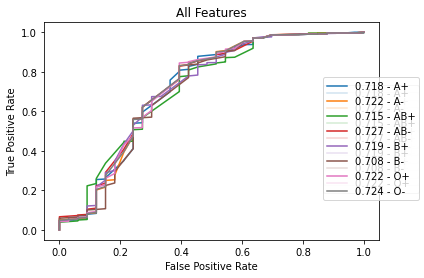

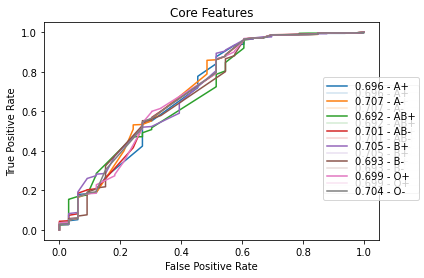

In [20]:
print("Ada Boost Classifier")
my_AdaBoost = AdaBoostClassifier(n_estimators=14, random_state=4)
AUCBloodTypeComparison( my_AdaBoost)

Logistic Regression


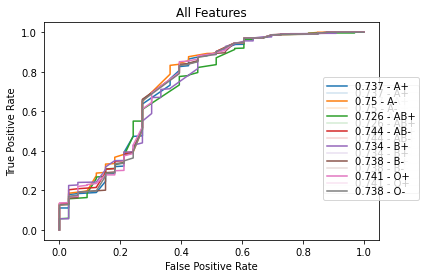

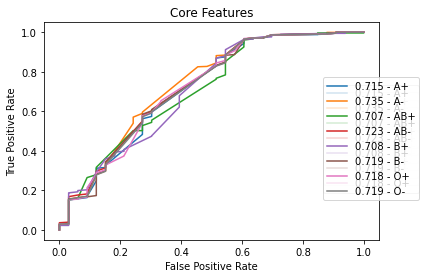

In [16]:
print("Logistic Regression")
my_logreg = LogisticRegression(max_iter=10000)
AUCBloodTypeComparison(my_logreg)

Decision Tree


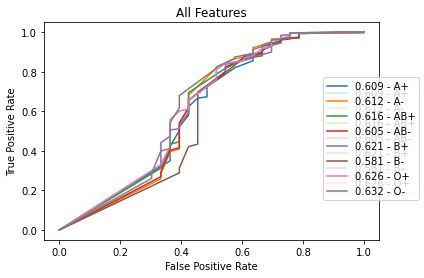

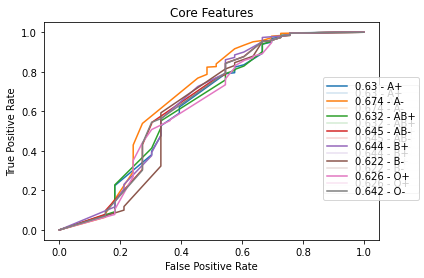

In [17]:
print("Decision Tree")
my_DecisionTree = DecisionTreeClassifier(random_state=4)
AUCBloodTypeComparison(my_DecisionTree)

Random Forest Classifier


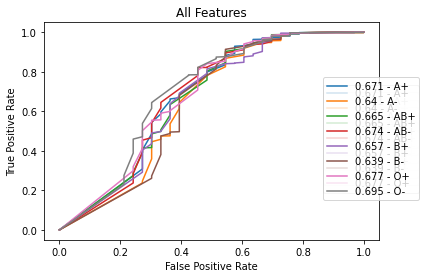

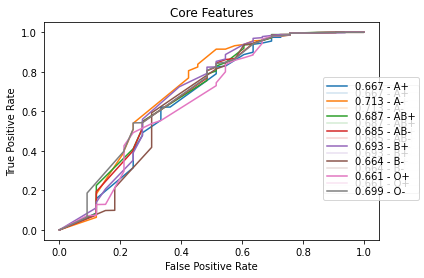

In [18]:
print("Random Forest Classifier")
my_RandomForest = RandomForestClassifier(n_estimators=29, bootstrap=True, random_state=4)
AUCBloodTypeComparison(my_RandomForest)

SVM


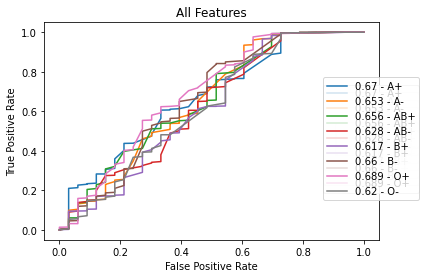

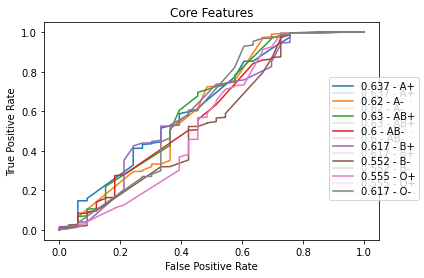

In [19]:
print("SVM")
my_svm = SVC(kernel='rbf', probability=True)
AUCBloodTypeComparison(my_svm)